In [3]:
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import weibull_min

# populations model

In [5]:
pop_eu = pd.read_csv("populationsdata/unpopulation_dataportal_EU.csv")
pop_na = pd.read_csv("populationsdata/unpopulation_dataportal_NA.csv")
pop_eu["region"] = "eu"
pop_na["region"] = "na"

In [6]:
pop = pd.concat([pop_eu,pop_na])

In [7]:

def lowe_syndrome_projection(pop_data, prevalence, max_lifespan, shape, scale):
    lowe_syndrome_data = []
    
    # Initialize the number of people with Lowe syndrome in 2023
    total_population_2023 = pop_data[pop_data['Time'] == 2023]['Value'].sum()
    lowe_syndrome_2023 = total_population_2023 * prevalence
    
    # Generate the age distribution for 2023 using the Weibull distribution
    age_range = np.arange(0, max_lifespan + 1)
    age_distribution = weibull_min.pdf(age_range, shape, loc=0, scale=scale)
    age_distribution /= age_distribution.sum()  # Normalize the distribution
    
    # Apply the age distribution to the estimated number of individuals with Lowe syndrome in 2023
    lowe_syndrome_age_breakdown_2023 = np.round(lowe_syndrome_2023 * age_distribution)
    
    # Assign unique IDs to individuals with Lowe syndrome in 2023 based on their age group
    lowe_syndrome_ids_2023 = []
    current_id = 0
    for age, count in enumerate(lowe_syndrome_age_breakdown_2023):
        for _ in range(int(count)):
            lowe_syndrome_ids_2023.append((current_id, 2023, age))
            current_id += 1
    
    lowe_syndrome_data.append(lowe_syndrome_ids_2023)
    
    for year in range(2024, 2041):
        prev_year_data = lowe_syndrome_data[-1]
        current_year_pop = pop_data.loc[(pop_data['Time'] == year) & (pop_data["Age"] == "0")].Value.sum()
        
        # Calculate new cases for the current year based on population data
        new_cases = current_year_pop * prevalence
        
        # Age the existing individuals by 1 year and remove individuals above 40 years old
        current_year_data = []
        for id, prev_year, age in prev_year_data:
            if age < max_lifespan:
                current_year_data.append((id, year, age + 1))
        
        # Add new cases to the current year's data
        new_ids = range(current_id, current_id + int(new_cases))
        new_cases_data = [(id, year, 0) for id in new_ids]
        current_year_data.extend(new_cases_data)
        
        current_id += int(new_cases)
        
        lowe_syndrome_data.append(current_year_data)
    
    return lowe_syndrome_data

pop_data = pop_na.copy()

prevalence = 1/500000
max_lifespan = 40
shape = 2
scale = 15

lowe_syndrome_data = lowe_syndrome_projection(pop_data, prevalence, max_lifespan, shape, scale)
lowe_syndrome_df = pd.DataFrame([], columns=['ID', 'Year', 'Age'])

for year_data in lowe_syndrome_data:
    df = pd.DataFrame(year_data, columns=['ID', 'Year', 'Age'])
    lowe_syndrome_df = pd.concat([lowe_syndrome_df, df], ignore_index=True)
lowe_syndrome_df = lowe_syndrome_df.groupby(["Year","Age"]).ID.count().reset_index()
lowe_syndrome_df.ID.name = "Value"

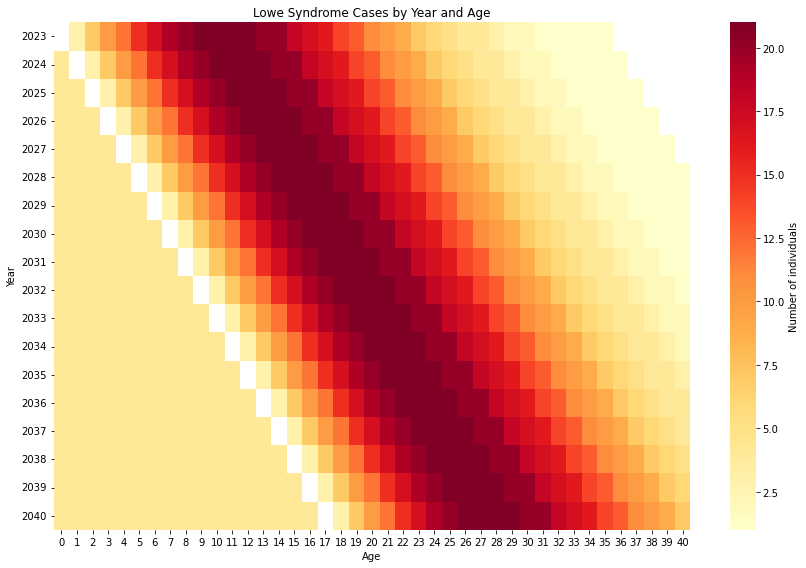

In [9]:

# Pivot the dataframe to create a matrix suitable for a heatmap
heatmap_data = lowe_syndrome_df.pivot(index='Year', columns='Age', values='ID')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlOrRd', cbar_kws={'label': 'Number of individuals'})

plt.title('Lowe Syndrome Cases by Year and Age')
plt.xlabel('Age')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

# Monte Carlo Simulation

In [10]:
num_simulations = 1
market_penetration_range = (0.1, 0.3)
pricing_range = (3e6, 5e6)
manufacturing_cost_range = (5e5, 1e6)
discount_rate = 0.1
phase1_success_range = (0.75, 0.8)
phase2_success = 0.5
phase3_success = 0.75
adoption_start = 0.2
adoption_end = 1
adoption_years = 5
odd_likelihood = 0.8
prdd_likelihood = 0.6
seed_funding_range = (1.5e6, 3e6)
vc_funding_range = (5e6, 10e6)
series_b_funding_range = (15e6, 30e6)

In [11]:
npv_array = np.zeros(num_simulations)
roi_array = np.zeros(num_simulations)

In [16]:
for i in range(num_simulations):
    market_penetration = np.random.uniform(*market_penetration_range)
    pricing = np.random.uniform(*pricing_range)
    manufacturing_cost = np.random.uniform(*manufacturing_cost_range)
    phase1_success = np.random.uniform(*phase1_success_range)

    odd_obtained = np.random.choice([True, False], p=[odd_likelihood, 1 - odd_likelihood])
    prdd_obtained = np.random.choice([True, False], p=[prdd_likelihood, 1 - prdd_likelihood])

    # Pre-Clinical Development Phase
    pre_clinical_duration = np.random.randint(2, 5)
    pre_clinical_cost = np.random.uniform(2.65, 5.85)

    # Clinical Development Phase
    clinical_duration = np.random.randint(4, 7)
    phase1_cost = np.random.uniform(2, 4)
    phase2_cost = np.random.uniform(5, 10)
    phase3_cost = np.random.uniform(20, 30)

    # FDA Approval and Commercialization Phase
    fda_approval_duration = 1
    fda_approval_cost = np.random.uniform(1.9, 3.35)

    # Adjust costs and development time based on ODD and PRDD
    if odd_obtained:
        phase1_cost *= 0.5
        phase2_cost *= 0.5
        phase3_cost *= 0.5
        clinical_duration = int(clinical_duration * 0.7)

    if prdd_obtained:
        fda_approval_duration = 0.5
        fda_approval_cost *= 0.8

    total_duration = pre_clinical_duration + clinical_duration + fda_approval_duration
    development_costs = pre_clinical_cost + phase1_cost + phase2_cost + phase3_cost + fda_approval_cost

    adoption_rate = np.linspace(adoption_start, adoption_end, adoption_years)
    revenue = np.zeros(int(total_duration) + adoption_years)
    costs = np.zeros(int(total_duration) + adoption_years)

In [17]:
for j in range(adoption_years):
        year = int(total_duration) + j + lowe_syndrome_df['Year'].min()
        som = lowe_syndrome_df[(lowe_syndrome_df['Year'] == year)&(lowe_syndrome_df["Age"] <=18)]['ID'].sum()
        revenue[int(total_duration) + j] = som * market_penetration * pricing * adoption_rate[j]
        costs[int(total_duration) + j] = manufacturing_cost * som * market_penetration * adoption_rate[j]

In [18]:
costs[:pre_clinical_duration] = pre_clinical_cost / pre_clinical_duration
costs[pre_clinical_duration:pre_clinical_duration+clinical_duration] = (phase1_cost + phase2_cost + phase3_cost+fda_approval_cost) / clinical_duration

In [19]:
# Determine funding amounts based on drawn values
seed_funding = np.random.uniform(*seed_funding_range)
vc_funding = np.random.uniform(*vc_funding_range) * (development_costs / (phase1_cost + phase2_cost + phase3_cost))
series_b_funding = np.random.uniform(*series_b_funding_range) * (revenue[-1] / pricing)

# Initialize cash flows with investments
cash_flows = np.zeros(int(total_duration) + adoption_years)
cash_flows[0] = -seed_funding
cash_flows[pre_clinical_duration] = -vc_funding
cash_flows[pre_clinical_duration + int(clinical_duration / 2)] = -series_b_funding

probability_success = phase1_success * phase2_success * phase3_success
# Add revenue and costs to cash flows
cash_flows[int(total_duration):] += probability_success * (revenue[int(total_duration):] - costs[int(total_duration):])

npv_array[i] = npf.npv(discount_rate, cash_flows)

total_investment = seed_funding + vc_funding + series_b_funding
net_profit = np.sum(cash_flows)
roi_array[i] = (net_profit / total_investment) * 100

In [20]:
cash_flows[0]

-2101135.9820674676

In [21]:
costs

array([1.44312474e+00, 1.44312474e+00, 1.44312474e+00, 1.44312474e+00,
       6.90005243e+00, 6.90005243e+00, 6.90005243e+00, 0.00000000e+00,
       3.38686180e+06, 6.12313997e+06, 8.20883453e+06, 9.72048471e+06,
       1.07154950e+07])

In [22]:
def monte_carlo_financial_projection(lowe_syndrome_df, num_simulations, market_penetration_range, pricing_range,
                                     manufacturing_cost_range, development_time_range, development_costs_range,
                                     discount_rate, phase1_success_range, phase2_success, phase3_success,
                                     adoption_start, adoption_end, adoption_years):
    npv_array = np.zeros(num_simulations)    roi_array = np.zeros(num_simulations)

    for i in range(num_simulations):
        market_penetration = np.random.uniform(*market_penetration_range)
        pricing = np.random.uniform(*pricing_range)
        manufacturing_cost = np.random.uniform(*manufacturing_cost_range)
        development_time = np.random.randint(*development_time_range)
        development_costs = np.random.uniform(*development_costs_range)
        phase1_success = np.random.uniform(*phase1_success_range)

        adoption_rate = np.linspace(adoption_start, adoption_end, adoption_years)
        revenue = np.zeros(development_time + adoption_years)
        costs = np.zeros(development_time + adoption_years)

        for j in range(adoption_years):
            year = development_time + j + lowe_syndrome_df['Year'].min()
            som = lowe_syndrome_df[lowe_syndrome_df['Year'] == year]['Value'].values[0]
            revenue[development_time + j] = som * market_penetration * pricing * adoption_rate[j]
            costs[development_time + j] = manufacturing_cost * som * market_penetration * adoption_rate[j]

        costs[:development_time] = development_costs / development_time

        probability_success = phase1_success * phase2_success * phase3_success

        cash_flows = probability_success * (revenue - costs)
        npv_array[i] = npf.npv(discount_rate, cash_flows)

        total_investment = np.sum(development_costs + manufacturing_cost)
        net_profit = np.sum(cash_flows)
        roi_array[i] = (net_profit / total_investment) * 100

    mean_npv = np.mean(npv_array)
    mean_roi = np.mean(roi_array)
    percentiles_npv = np.percentile(npv_array, [5, 50, 95])
    percentiles_roi = np.percentile(roi_array, [5, 50, 95])

    return mean_npv, mean_roi, percentiles_npv, percentiles_roi

# Define the input parameters
num_simulations = 10000
market_penetration_range = (0.1, 0.3)
pricing_range = (3e6, 5e6)
manufacturing_cost_range = (5e5, 1e6)
development_time_range = (6, 9)
development_costs_range = (3e7, 7e7)
discount_rate = 0.1
phase1_success_range = (0.75, 0.8)
phase2_success = 0.5
phase3_success = 0.75
adoption_start = 0.2
adoption_end = 1
adoption_years = 5

# Perform the Monte Carlo financial projection
mean_npv, mean_roi, percentiles_npv, percentiles_roi = monte_carlo_financial_projection(
    lowe_syndrome_df, num_simulations, market_penetration_range, pricing_range,
    manufacturing_cost_range, development_time_range, development_costs_range,
    discount_rate, phase1_success_range, phase2_success, phase3_success,
    adoption_start, adoption_end, adoption_years
)

print("Mean NPV:", mean_npv)
print("Mean ROI:", mean_roi)
print("Percentiles NPV (5th, 50th, 95th):", percentiles_npv)
print("Percentiles ROI (5th, 50th, 95th):", percentiles_roi)

SyntaxError: invalid syntax (4191011601.py, line 5)

# OLD

In [12]:
# Define the input parameters
num_simulations = 10000
som = 310
market_penetration = np.random.uniform(0.1, 0.3, num_simulations)
pricing = np.random.uniform(3e6, 5e6, num_simulations)
manufacturing_cost = np.random.uniform(5e5, 1e6, num_simulations)
development_time = np.random.randint(6, 9, num_simulations)
development_costs = np.random.uniform(3e7, 7e7, num_simulations)
discount_rate = 0.1
phase1_success = np.random.uniform(0.75, 0.8, num_simulations)
phase2_success = 0.5
phase3_success = 0.75

# Define adoption rate parameters
adoption_start = 0.2
adoption_end = 1
adoption_years = 5

# Calculate revenue and costs for each simulation
npv_array = np.zeros(num_simulations)
roi_array = np.zeros(num_simulations)
for i in range(num_simulations):
    adoption_rate = np.linspace(adoption_start, adoption_end, adoption_years)
    revenue = np.zeros(development_time[i] + adoption_years)
    costs = np.zeros(development_time[i] + adoption_years)
    
    for j in range(adoption_years):
        revenue[development_time[i] + j] = som * market_penetration[i] * pricing[i] * adoption_rate[j]
        costs[development_time[i] + j] = manufacturing_cost[i] * som * market_penetration[i] * adoption_rate[j]
    
    costs[:development_time[i]] = development_costs[i] / development_time[i]
    
    probability_success = phase1_success[i] * phase2_success * phase3_success
    
    cash_flows = probability_success * (revenue - costs)
    npv_array[i] = npf.npv(discount_rate, cash_flows)
    # Calculate ROI
    total_investment = np.sum(development_costs[i] + manufacturing_cost[i])
    net_profit = np.sum(cash_flows)
    roi_array[i] = (net_profit / total_investment) * 100

# Calculate the mean and percentiles of the NPV distribution
mean_npv = np.mean(npv_array)
mean_roi = np.mean(roi_array)
percentiles_npv = np.percentile(npv_array, [5, 50, 95])
percentiles_roi = np.percentile(roi_array, [5, 50, 95])


print("Mean NPV:", mean_npv)
print("Mean ROI:", mean_roi)
print("Percentiles NPV (5th, 50th, 95th):", percentiles_npv)
print("Percentiles ROI (5th, 50th, 95th):", percentiles_roi)

Mean NPV: 59496124.14054653
Mean ROI: 336.8216844281644
Percentiles NPV (5th, 50th, 95th): [2.32948367e+07 5.69501380e+07 1.04897172e+08]
Percentiles ROI (5th, 50th, 95th): [130.24339529 308.61339555 638.06828262]
